Created on Tue March 11 16:38:45 2025

Notebook for force measurement - article 0

1. import libraries and new (corrected) exp2 functions
2. import main excel file data
3. import tracking data (support position, contact position,2 stem points near support)
4. import results from root_stem_extractor?
5. a. remove problematic events from raw data
5. b. get event types from excel: close2axis, multi-twine, simple twine/slip
6. populate event-class variables
9. figures:
    1. example: 
        a. X,Y,Z position of support
        b. X,Y,Z position of contact?
        c. angle of support
        d. Force trajectory
    2. Calibration and noise
    3. Angle and force trajectories per support mass
    4. CN distribution?
    5. Force derivative plots?


@author: Amir Ohad

In [14]:
# import libraries
# general
import sys
import numpy as np
import os,glob # for listing files in folder
import re # regular expressions
import pandas as pd
import scipy
import math as m
from tqdm import tqdm

# plots
import importlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.lines as mlines
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Plant and Event function file
import article0_funcs

# plot parameters
cmap = plt.get_cmap('viridis')
fs = 16 # standard font size for plots


print(os.getcwd())
Article_folder = os.getcwd()

save_folder = os.path.join(Article_folder,'test_Figures')

# sys.path.append('..')
# import useful_functions as uf 
# importlib.reload(uf)
# Article_folder = r'C:\Users\Amir\Documents\PHD\Thesis\My Articles\0 - Flexible dynamic force measurement method via physical pendulum'
# importlib.reload(article0_funcs)


c:\Users\Amir\Documents\PHD\Python\GitHub\Amir_Repositories\Ohad2025_PendulumForceMeasure


In [15]:
# Define functions for plots

def round_to_first_significant_digit(num):
    if num == 0:
        return 0
    
    # Find the order of magnitude (e.g., for 456, magnitude is 10^2)
    magnitude = m.floor(m.log10(abs(num)))
    
    # Normalize the number to have its first significant digit as the most significant
    normalized_num = num / (10 ** magnitude)
    
    # Round to 1 significant digit
    rounded_num = round(normalized_num, 1)
    
    # Scale the number back to the original magnitude
    return rounded_num * (10 ** magnitude)

def set_grid(ax,x_range,y_range): 

    '''set grid for plot. take 1/5 of each range for major grid, 1/10 for minor'''
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.minorticks_on()
    ax.tick_params(axis='both', which='both', direction='in', length=5,
                   width=1, colors='black', grid_color='gray', grid_alpha=0.7)
    # Set major and minor grid spacing for x-axis and y-axis
    x_major_locator = plt.MultipleLocator(x_range / 5)
    x_minor_locator = plt.MultipleLocator(x_range / 10)
    y_major_locator = plt.MultipleLocator(y_range / 5)
    y_minor_locator = plt.MultipleLocator(y_range / 10)

    ax.xaxis.set_major_locator(x_major_locator)
    ax.xaxis.set_minor_locator(x_minor_locator)
    ax.yaxis.set_major_locator(y_major_locator)
    ax.yaxis.set_minor_locator(y_minor_locator)

    # Set major and minor tick labels with rounding to the first significant digit
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{round_to_first_significant_digit(x):g}'))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{round_to_first_significant_digit(y):g}'))

def linfunc(x,a,b): return a*x + b

def funcget_tracked_data(filename,view=[],camera='nikon'):
    '''get tracked data from file, return x,y,t, index, N- # of lines, C-max tracked obj,T-# of points per track'''
    with open(filename,"r") as datafile:
        lines= datafile.readlines()
        # del lines[0] # remove first line to avoid 2 zero times
        N=np.size(lines,0) # number of lines
        xtl=[[]]*N # x top left
        ytl=[[]]*N # y top left
        w=[[]]*N # box width
        h=[[]]*N # box height
        xcntr=[[]]*N # box x center
        ycntr=[[]]*N # box y center
        timer = np.zeros(N) # initialize timer array
        timer[0]=0 # time starts at zero
        i=0 # count rows
        index = 0
    # x,y,w,h ; start at upper left corner
        for line in lines:
            if line==[]: break
            currentline = line.split(",") # split by ','
            xtl[i]=float(currentline[0]) # xtl- x top left
            ytl[i]=float(currentline[1])
            w[i]=float(currentline[2])
            h[i]=float(currentline[3])
            xcntr[i]=xtl[i]+w[i]/2 # calculate x coordinate of box center
            ycntr[i]=ytl[i]-h[i]/2
            i+=1
            if i%50 ==0: 
                print(i)
                print(currentline)

        # timer = np.zeros(N) # initialize timer array
        dt = 1 # interval
        for i in range(N):
            timer[i] = timer[i-1]+dt # assign timer value for each index
        return xcntr,ycntr,timer,index,N
    
def fit_w_err(ax,x,dx,y,dy,fit_func = linfunc, data_color = 'blue',
              fit_color = 'red',add_legend = False, legend_loc='best',data_alpha=0.5):
    '''Fit data to the provided function and plot with error bars.

    Parameters:
    ax : matplotlib axis object
    x, dx : array-like, data and errors in x
    y, dy : array-like, data and errors in y
    fit_func : callable, function to fit the data
    data_color : str, color for the data points
    fit_color : str, color for the fitted curve
    legend_loc : str, location for the legend
    to_print : bool, whether to print function parameters on the plot

    Returns:
    popt : array, optimal values for the parameters
    pcov : 2D array, the estimated covariance of popt
    goodness of fit: R^2 and chi^2_red
    '''
    # Plot the data with error bars
    if add_legend: label_data='Data'
    else: label_data=None
    ax.errorbar(x, y, xerr=abs(dx), yerr=abs(dy), fmt='+',
                color=data_color,label=label_data, alpha=data_alpha)
    # fit with errors via curve fit
    popt,pcov = scipy.optimize.curve_fit(fit_func, x, y,
            p0=None, sigma=np.sqrt(dx**2+dy**2), absolute_sigma=True)
    ax.plot(x,(fit_func(x,*popt)),color=fit_color,
            label='Fit')#fit_func(x,*popt))

    # goodness of fit
    ss_total = np.sum((y - np.mean(y)) ** 2)
    line_of_best_fit = popt[0] * x + popt[1] # fit_func(x, *popt)
    residuals = y - line_of_best_fit
    ss_residual = np.sum(residuals**2)
    chi_squared_red = np.sum(residuals**2 / (dy**2+dx**2))/(len(x)-3)
    chi_sr_std = np.sqrt(2/(len(x)-3))
    r_squared = 1 - (ss_residual / ss_total)
    # need to fix printing of fitted values and goodness of fit for non-linear functions:
    # ax.plot(x,popt[0]*x+popt[1],'-',color=fit_color,
    #          label=rf'$\chi^{2}={chi_squared_red:.2f}, R^{2}: {r_squared:.2f}$,\
    #                  y = {popt[0]:.2f}x + {popt[1]:.2f} ')

    # upper =(popt[0]+np.diag(pcov)[0])*x+popt[1]+np.diag(pcov)[1]
    # lower = (popt[0]-np.diag(pcov)[0])*x+popt[1]-np.diag(pcov)[1]
    # ax.fill_between(np.arange(min(x),max(x),(max(x)-min(x))/len(x)),lower,upper)
    if add_legend: ax.legend(loc=legend_loc)
    # print(rf'{popt=},{pcov=},{chi_squared_red=:.2e},{chi_sr_std=:.2e},{r_squared=:.2e}')
    return popt,pcov,r_squared,chi_squared_red




In [16]:
# import data 

data_path = os.path.join(Article_folder,'Data')

excel_path = r'\Exp2_supplementary_measurements_events_xl.xlsx'

# straw exp data
data_panda = pd.read_excel(data_path+excel_path)

# import tracked data, initiate variables
track_sup_path = r'\track_logs'
track_folder_path = data_path+track_sup_path

track_contact_path = r'\contact_track_logs'
contact_folder_path = data_path+track_contact_path


N_track = len(os.listdir(track_folder_path)) # get number of files in track folder
N_contact=len(os.listdir(contact_folder_path)) # get number of files in contact folder
N_tot = len(data_panda) # get number of lines in excel


#%% remove problematic events from raw data
delete_rows = [] # save rows to delete
problem_exp = [] # exp_num of problem events

for i in range(N_tot): # remove problem events and non-Helda events
    if data_panda.at[i,'problem']!='na' or data_panda.at[i,'Bean_Strain']!='Helda':
        delete_rows.append(i)
        problem_exp.append(data_panda.at[i,'Exp_num'])
N = N_tot - len(delete_rows) # modify num of rows

data_panda = data_panda.drop(data_panda.index[delete_rows]) # remove prob. events
data_panda = data_panda.reset_index() # redo index

#%% get misc. file lists

# get track files for support bottom coordinates
remove_chars = re.compile('[,_\.!?]') # what to remove from strings
track_dict = {} # save support track in dictionary by exp and events
i=0 # start with first track file
for file in glob.glob(os.path.join(track_folder_path, '*.txt')): # for each event:
    exp = int(re.findall('_\d{3,4}_',file)[0].replace('_','')) # find exp number (3-4 digits)
    event = int(re.findall('[0-9]',re.findall('_\d{1}\D',file)[0].replace('_',''))[0]) # find event number
    viewt = re.findall('(side{1}|top{1})',file)[0] #.replace('_','')
    track_dict[(exp,event,viewt)] = [file] # add new exp
    i+=1

# get track files for stem-support contact coordinates
contact_dict = {} # save support contact track in dictionary by exp and events
i=0 # start with first contact file
for file in glob.glob(os.path.join(contact_folder_path, '*.txt')): # for each event:
    exp = int(re.findall('_\d{3,4}_',file)[0].replace('_','')) # find exp number (3-4 digits)
    event = int(re.findall('_[0-9]_',file)[0].replace('_','')) # find event number
    contact_dict[(exp,event)] = [file] # add new exp
    i+=1


# root_path = r'C:\Users\Amir\Documents\PHD\Experiments\Force Measurements'
# basepath = root_path+r'\Exp2_Pendulum' # pendulum exp folder
# excel_csv= r'\Exp2_supplementary_measurements_events.csv'
# data_panda = pd.read_csv(basepath+excel_csv)
# track_near_sup_path = r'\twine_init_logs'
# track_near_sup_folder_path = basepath+track_near_sup_path
# h5_path = r'\Measurements\root_stem_results'
# h5_folder_path = basepath+h5_path
# E_path = r'\Young_moduli'
# E_folder_path = basepath+E_path
# N_E = len(os.listdir(E_folder_path))

# get track files for 2 stem positions on either side of support
# near_sup_track_dict = {}
# i=0 # start with first stem_near_sup file
# for file in glob.glob(os.path.join(track_near_sup_folder_path, '*.txt')): # for each event:
#     exp = int(re.findall('_\d{3,4}_',file)[0].replace('_','')) # find exp number (3-4 digits)
#     event = int(re.findall('_[0-9]_',file)[0].replace('_','')) # find event number
#     near_sup_track_dict[(exp,event)] = [file] # add new exp
#     i+=1

# get h5 files for stem near support
# h5_dict = {}
# i=0 # start with first h5 file
# for file in glob.glob(os.path.join(h5_folder_path, '*.h5')): # for each event:
#     exp = int(re.findall('interekt_\d{2,3}_',file)[0].split('_')[1]) # find exp number (3-4 digits)
#     event = int(re.findall('e_[0-9]_',file)[0].split('_')[1]) # find event number
#     start_frame = int(re.findall('_\d{2,5}-\d{2,5}',file)[0].replace('_','').split('-')[0]) # find start frame
#     h5_dict[(exp,event,start_frame)] = [file] # add new exp
#     i+=1

# get Young modulus files
# E_dict = {}
# for file in glob.glob(os.path.join(E_folder_path, '*.csv')):
#     exp = int(re.findall('\d{2,3}',file)[0])
#     E_dict[exp]=pd.read_csv(file,header=None)


In [17]:
# clear plants and events
plants = []
events = []
#%% populate plant and event instances
i = 0
N = len(data_panda)
for i in tqdm(range(N)): # N
    try:
        exp = int(re.findall('\d{3,4}',data_panda.at[i,'Exp_num'])[0]) # exp num
        view = data_panda.at[i,'View']  # side of top view
        if view == 'top':
            plants[-1].pix2cm_t = float(data_panda.at[i,'Top_pix2cm'])

        if i==0 or exp!=plants[-1].exp_num: # append new plant with data from pandas
            #basic data
            plants.append(article0_funcs.Plant(data_panda,data_path,i,exp))
            # view dependent data
            plants[-1].view_data(data_panda,i)
            # circumnutation data
            plants[-1].cn_data(data_panda,i)
            #Youngs modulus by segment with avg
            # plants[-1].getE(E_dict)


        event =  int(re.findall('_[0-9]',data_panda.at[i,
        'Exp_num'])[0].replace('_','')) # get event number


        # if this is the 1st event or the previous event_num is different from the current one:
        # add new event to list
        if len(events)==0 or events[-1].event_num != event or \
            events[-1].p.exp_num != exp:
            events.append(article0_funcs.Event(plants[-1],data_panda,i))
        events[-1].event_num = event

        # view dependent data
        events[-1].view_data(data_panda,i,view)

        # get automated extraction of twine(decision) time
        # events[-1].get_twine_time(exp,event,view,
        #                   h5_dict,near_sup_track_dict,50,track_dict,to_plot=0)


        # get track data, select decision period data, pix2cm,
        events[-1].event_base_calcs(view,track_dict,contact_dict)
        # calc
        events[-1].event_calc_variables(view)
        # print(f'i={i}, exp number {exp}, {event}') # print progress
    except Exception as e:
        print(f'Error at i={i}, exp number {exp}, {event}')
        print(e)
        
        continue


  0%|          | 0/324 [00:00<?, ?it/s]

100%|██████████| 324/324 [00:09<00:00, 33.96it/s]


Slip:True


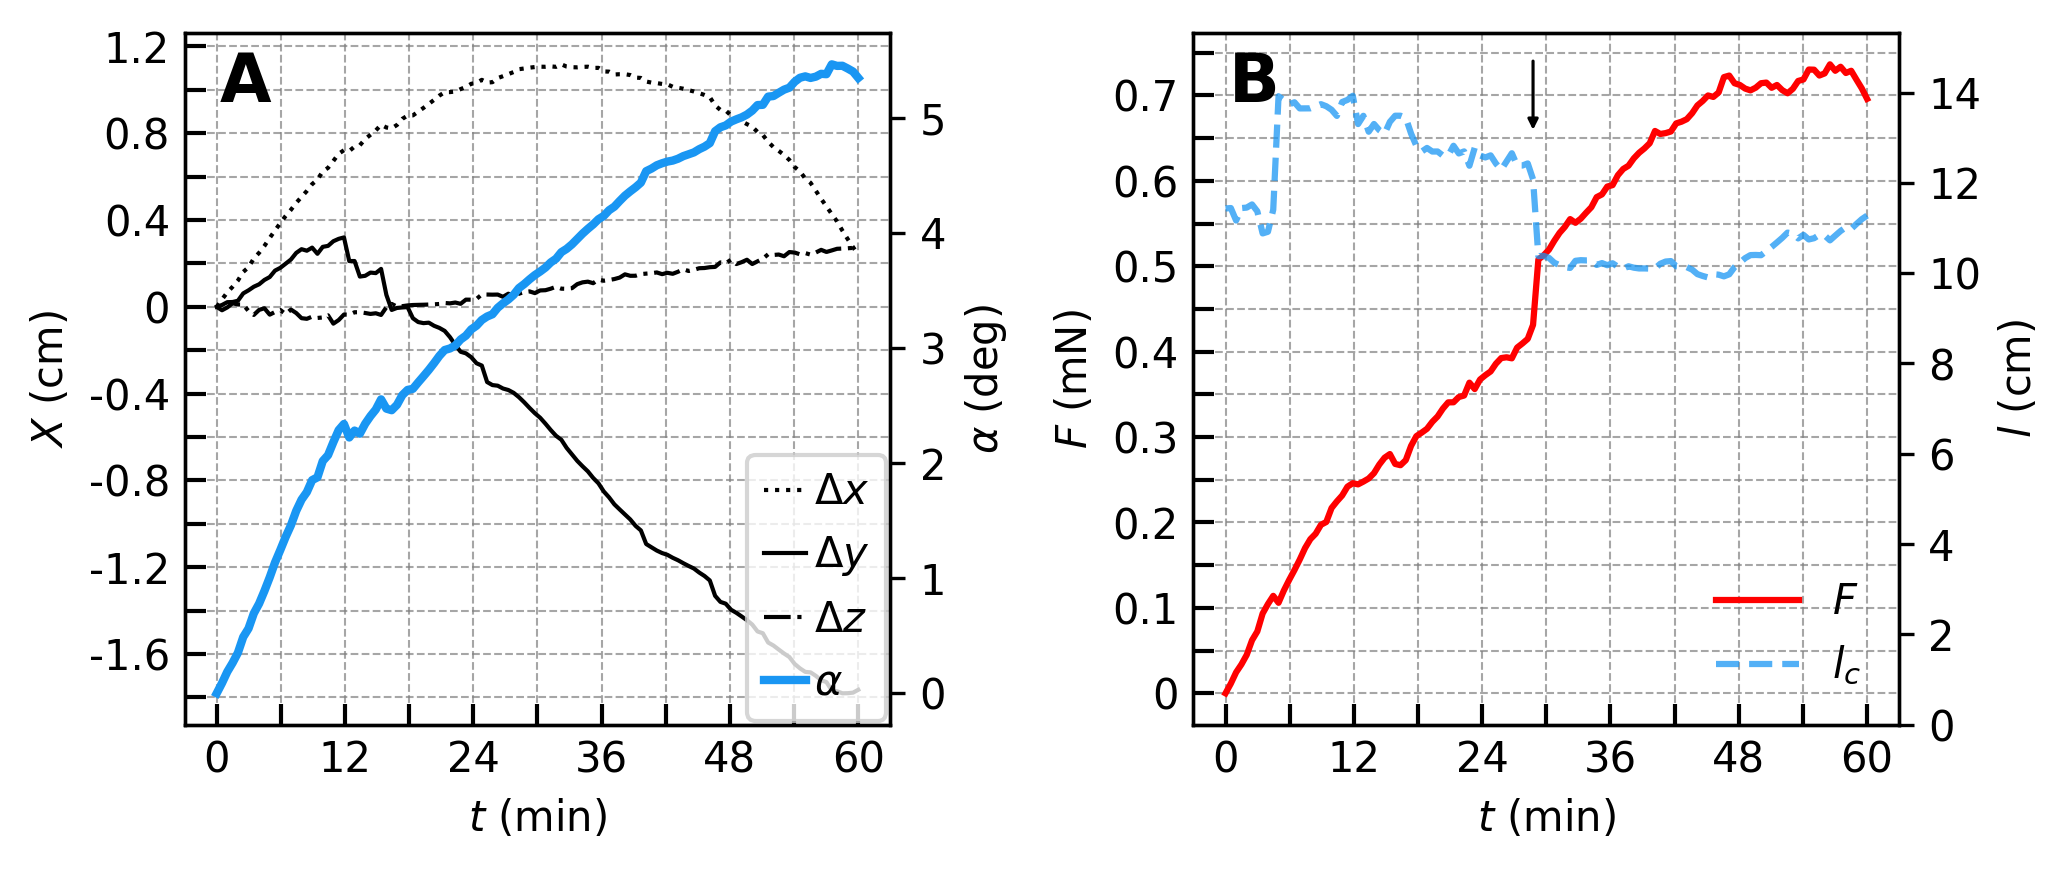

In [18]:
# Force trajectory for slip event with contact position along support
# cmap = plt.get_cmap('viridis')
cmap = plt.get_cmap('rainbow')
i_exmp = 60 # 40 (simple) , 20,120 (bump from dist2tip)
event_exmp = events[i_exmp]
max_time = event_exmp.timer[-1]/60

# check events are correctly classified
print("Slip:"+ str( event_exmp.twine_state==0))

fig, axs = plt.subplots(1, 2, figsize=(7, 3), dpi=300)
# add subplot labels
axs[0].text(0.05, 0.9, 'A', fontsize=fs, fontweight='bold', transform=axs[0].transAxes)
axs[1].text(0.05, 0.9, 'B', fontsize=fs, fontweight='bold', transform=axs[1].transAxes)

# Plot xyz coordinates
xyz = event_exmp.xyz
axs[0].plot(event_exmp.timer/60, xyz[0,::]-xyz[0,0], color='black', 
            linestyle = 'dotted', linewidth = 1, label=r'$\Delta x$') #cmap(0.1)
axs[0].plot(event_exmp.timer/60, xyz[1,::]-xyz[1,0], color='black', 
            linestyle = '-', linewidth = 1, label=r'$\Delta y$') #cmap(0.5)
axs[0].plot(event_exmp.timer/60, xyz[2,::]-xyz[2,0], color='black', 
            linestyle = 'dashdot', linewidth = 1, label=r'$\Delta z$') #cmap(0.9)

# Plot angle on the same figure with different axis
axs0 = axs[0].twinx()
axs0.plot(event_exmp.timer/60, np.rad2deg(event_exmp.alpha), color=cmap(0.2), linewidth = 2, label=r'$\alpha$') #cmap(0.2)
# add legend label from the twin axis
lines, labels = axs[0].get_legend_handles_labels()
lines2, labels2 = axs0.get_legend_handles_labels()

# set axis and grid
axs[0].set_xlabel(r'$t$ (min)')
axs[0].set_ylabel(r'$X$ (cm)')
# axs0.set_ylim([0,10])
# set_grid(axs[0],max_time,5)
set_grid(axs[0],max_time,2)

# axs0.set_xlabel(r'$t$ (min)')
axs0.set_ylabel(r'$\alpha$ (deg)')

# Adjust the legend properties

axs[0].legend(
    lines + lines2, labels + labels2,
    loc='lower right',          # Place legend
    frameon=True,              # Remove the frame
    handlelength=1,             # Shorter line elements
    handletextpad=0.2,          # Reduce space between handle and text
    borderaxespad=0.1,          # Reduce space between legend and inset plot edge
    fontsize=10                 # Smaller font size for better fit
)


###########################################
# Plot calculated force and contact position

axs[1].plot(event_exmp.timer/60, event_exmp.F_bean,
             color=cmap(1.5), label=r'$F$') #cmap(0.2)
ax2 = axs[1].twinx()
dist2tip = [abs(k) for k in event_exmp.l_contact] # ?
# ax2.plot(event_exmp.timer/60, dist2tip, color='gray', label=r'$l$', alpha=0.75) # cmap(0.7)

# axs[1].vlines(event_exmp.timer[-1]/60, 0, event_exmp.F_bean[-1]*mg2mN,
#                color=cmap(1.5), linestyle='dotted')
ax2.plot(event_exmp.timer/60, dist2tip, color= cmap(0.2), linestyle='dashed',
          label=r'$l_c$', alpha=0.75)
lines, labels = axs[1].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
axs[1].legend(lines + lines2, labels + labels2, loc='best',frameon=False)



# draw a small downward arrow at rapid force increase
x0 = 29
y0 = 0.65
axs[1].annotate(
    '',                    # no text
    xy=(x0, y0),           # arrow tip
    xytext=(x0, y0 + 0.1), # arrow tail (0.5 units above)
    arrowprops=dict(
        arrowstyle='-|>',  # simple arrow head
        lw=0.75,            # line width of arrow shaft
        mutation_scale=5, # size of arrow head
        color='black'
    )
)

ax2.set_ylabel(r'$l$ (cm)')
ax2.set_ylim([0,max(dist2tip)*1.1])
axs[1].set_xlabel(r'$t$ (min)')
axs[1].set_ylabel(r'$F$ (mN)')
set_grid(axs[1],max_time,0.5)
# set_grid(ax2,max_time,17.5)

plt.tight_layout()
plt.show()
fig.savefig(save_folder+r'\xyz_ang_F_l_2.pdf',dpi=300)

50
['2619.0', ' 1991.0', ' 144.0', ' 116.0', ' C:\\Users\\Amir\\Documents\\PHD\\Experiments\\Force Measurements\\Exp2_Pendulum\\Calibrations\\fluctuations_1sec_int\\DSC_8205.JPG', ' 2024-05-11 13:07', ' 0', ' Auto\n']
100
['2640.0', ' 1994.0', ' 120.0', ' 97.0', ' C:\\Users\\Amir\\Documents\\PHD\\Experiments\\Force Measurements\\Exp2_Pendulum\\Calibrations\\fluctuations_1sec_int\\DSC_8255.JPG', ' 2024-05-11 13:08', ' 0', ' Auto\n']
pix2cm=0.0019 cm/pix,std_noise=0.096 mm
d_alpha_noise=0.00029 rad , np.rad2deg(d_alpha_noise)=0.016 deg
err_res_pix=7.1 cm/pix,err_res_mm=0.13 mm
D_mm=20 mm,dD_mm=0.16 mm,L_mm=1.8e+02 mm,dL_mm=0.13 mm,h_tip_mm=12 mm,      dh_tip_mm=0.13 mm,A=0.059,alpha_error_calc=0.0005 rad, F_min_mN=0.002 mN


C:\Users\Amir\AppData\Local\Temp\ipykernel_1860\1319385647.py:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


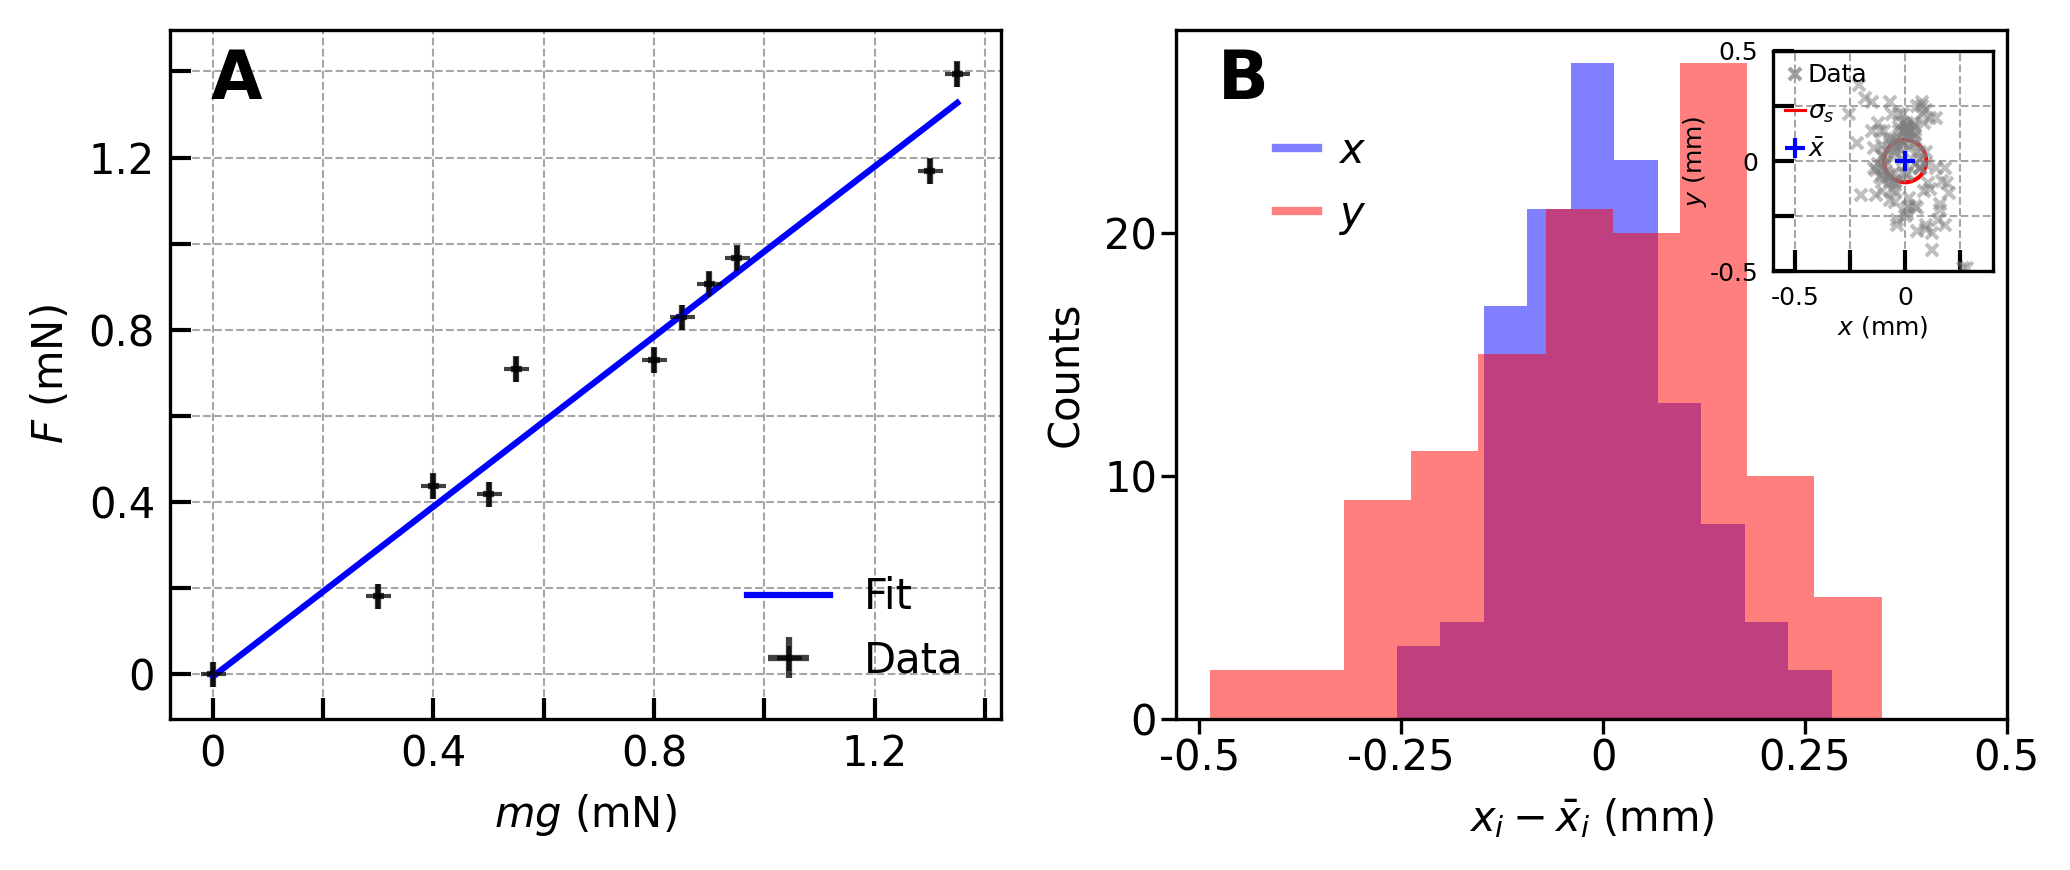

In [19]:
# combined plot of calibration (A) and noise (B)

# test = r"C:\Users\Amir\Documents\PHD\Python\GitHub\Amir_Repositories\Repo_article0\CSRT_fluctuations_1sec_interval.txt"
fluctuation_track_file = os.path.join(data_path, r'fluctuations\CSRT_fluctuations_1sec_interval.txt')


xcntr,ycntr,timer,index,N = funcget_tracked_data(fluctuation_track_file)
pend_diam_pix = 423 # width of the pendulum from top view
pend_diam_cm = 0.8
L_cm = 18 
pix2cm = pend_diam_cm/pend_diam_pix 
L_mm = L_cm*10
h_tip = np.mean([events[i].L_track2suptip_cm for i in range(len(events))])
h_tip_mm = h_tip*10

fig, ax = plt.subplots(1, 2, figsize=(7, 3), dpi=300)
ax[0].text(0.05, 0.9, 'A', fontsize=fs, fontweight='bold', transform=ax[0].transAxes)
ax[1].text(0.05, 0.9, 'B', fontsize=fs, fontweight='bold', transform=ax[1].transAxes)


############################################################
x = np.subtract(xcntr, np.mean(xcntr))*pix2cm*10 # x10 for mm
y = np.subtract(ycntr, np.mean(ycntr))*pix2cm*10 # x10 for mm

# Plot the distribution
ax[1].hist(x, alpha=0.5, color='blue', label=r'$x$')
ax[1].hist(y, alpha=0.5, color='red', label=r'$y$')
ax[1].set_xlabel(r'$x_{i} - \bar{x}_{i}$ (mm)')
ax[1].set_ylabel('Counts')
# Control x-tick and y-tick positions
ax[1].set_xticks([-0.5, -0.25, 0, 0.25, 0.5])  # Set specific tick positions
ax[1].set_xticklabels([-0.5, -0.25, 0, 0.25, 0.5], fontsize=10)  # Set specific tick labels with fontsize
ax[1].set_yticks([0, 10, 20])  # Set specific y-tick positions
ax[1].set_yticklabels([0, 10, 20], fontsize=10)  # Set specific y-tick labels with fontsize
# Adjust tick labels' padding
ax[1].tick_params(axis='x', pad=1)  # Move x-axis labels closer to the ticks
ax[1].tick_params(axis='y', pad=1)  # Move y-axis labels closer to the ticks

# Create a custom legend element for the noise distribution
legend_elements = [
    Line2D([0], [0], color='blue',alpha=0.5, lw=2, linestyle='-', label=r'$x$'),  # Data points
    Line2D([0], [0], color='red', lw=2, alpha=0.5, linestyle='-', label=r'$y$'),  # Straight red line
]
# ax[1].legend(loc='best',frameon=False)
# Add the custom legend elements to the plot
ax[1].legend(
    handles=legend_elements,
    loc='upper left',          # Place in the upper-right corner
    frameon=False,              # Remove the frame
    handlelength=1,             # Shorter line elements
    handletextpad=0.5,          # Reduce space between handle and text
    borderaxespad=2,          # Reduce space between legend and inset plot edge
    fontsize=10                 # Smaller font size for better fit
)


############################################################
# Create inset axes
ax_inset = inset_axes(ax[1], width="40%", height="40%",# loc='upper right',
                      bbox_to_anchor=(0.22, 0.2,0.82,0.8), bbox_transform=ax[1].transAxes)
ax_inset.set_ylim([-0.5,0.5])
ax_inset.set_xlim([-0.6,0.4])
ax_inset.set_xlabel(r'$x$ (mm)',fontsize=6,labelpad=1)
ax_inset.set_ylabel(r'$y$ (mm)',fontsize=6,labelpad=0)
ax_inset.tick_params(axis='both', length=2)  # Make both x and y axis ticks shorter
ax_inset.tick_params(axis='both', width=0.5)  # Make both x and y axis ticks thinner
ax_inset.tick_params(axis='both', labelsize=6)  # Make both x and y axis labels smaller
set_grid(ax_inset,2.5,2.5)

# Increase the x and y scales of the main plot
# ax[0].set_xlim([-0.4, 0.6])
# ax[0].set_ylim([-0.3, 0.6])
# Ensure the x and y axes are plotted on the same scale
ax_inset.set_aspect('equal', adjustable='box')

# calculate the mean and standard deviation of the data
# calculate mean
ax_inset.plot(x,y,'x',color='grey',alpha=0.5,label = 'Data',markersize=3)
# plot the mean
ax_inset.plot(np.mean(x),np.mean(y),'b+',markersize=5,label={r'$\bar{x}$'})
# calculate the std
std_noise = np.std(np.sqrt(x**2 + y**2)) # in mm
# Plot a thin red circle with a radius of the standard deviation around the mean
circle_noise = plt.Circle((np.mean(x), np.mean(y)), std_noise, color='red', fill=False, linewidth=1,label=r'$\sigma_{noise}$')
# Plot a thin red circle with a radius of the pendulum around the mean
circle_diameter = plt.Circle((np.mean(x), np.mean(y)), pend_diam_cm/2*10, color='red', fill=False, linewidth=0.5)
# plt.gca().add_artist(circle_diameter)
ax_inset.add_artist(circle_noise)

# Create a custom legend element for the noise and data
legend_elements = [
    Line2D([0], [0], marker='x', color='grey', markersize=3, alpha=0.75, linestyle='None', label='Data'),  # Data points
    Line2D([0], [0], color='red', lw=0.75, linestyle='-', label=r'$\sigma_{s}$'),  # Straight red line
    Line2D([0], [0], marker='+', color='blue', markersize=5, linestyle='None', label=r'$\bar{x}$') # mean point
]

# Adjust the legend properties
ax_inset.legend(
    handles=legend_elements,
    loc='upper left',          # Place in the upper-right corner
    frameon=False,              # Remove the frame
    handlelength=0.8,           # Shorter line elements
    handletextpad=0.1,          # Reduce space between handle and text
    borderaxespad=0.1,          # Reduce space between legend and inset plot edge
    fontsize=6                  # Smaller font size for better fit
)

############################################################
# errors
std_noise = np.std(np.sqrt(x**2 + y**2)) # in mm
print(f'{pix2cm=:.2g} cm/pix,{std_noise=:.2g} mm')
d_alpha_noise = m.asin((std_noise/2)/(L_mm-h_tip_mm))
print(f'{d_alpha_noise=:.2g} rad , {np.rad2deg(d_alpha_noise)=:.2g} deg')
# error from resolution:
# distance error is ssq of individual measurement errors ~ 2 pixels per measurement
trk_pix_err = 5 # pixel tracking error estimation 
err_res_pix = m.sqrt(trk_pix_err**2 + trk_pix_err**2)
err_res_mm = err_res_pix*pix2cm*10
print(f'{err_res_pix=:.2g} cm/pix,{err_res_mm=:.2g} mm')

# sum errors from resolution and noise:
D_mm = 20 # mean deflection in mm 
dD_mm = np.sqrt(std_noise**2 + (err_res_pix*pix2cm*10)**2) # in mm
dh_tip_mm = err_res_pix*pix2cm*10
dL_mm = err_res_pix*pix2cm*10
A = D_mm/(2*(L_mm-h_tip_mm))
alpha_error_calc = 1/(1-A**2)*np.sqrt((A*dD_mm/D_mm)**2+(A*dL_mm/(L_mm-h_tip_mm))**2+(A* dh_tip_mm/(L_mm-h_tip_mm))**2)
F_min_mg = 1000*0.8 * m.tan(alpha_error_calc)/2
F_min_mN = F_min_mg * 1e-2
print(f'{D_mm=:.2g} mm,{dD_mm=:.2g} mm,{L_mm=:.2g} mm,{dL_mm=:.2g} mm,{h_tip_mm=:.2g} mm,\
      {dh_tip_mm=:.2g} mm,{A=:.2g},{alpha_error_calc=:.2g} rad, {F_min_mN=:.2g} mN')

############################################################

#%% Calibration graph for force
# file = r"C:\Users\Amir\Documents\PHD\Thesis\My Articles\0 - Flexible dynamic force measurement method via physical pendulum\Data\Force calibration data 1\force_calibration_curve.xlsx"
calibration_data_file = os.path.join(data_path, r'Force calibration\force_calibration_curve.xlsx')
calib_data = pd.read_excel(calibration_data_file)
calib_data = calib_data.dropna()

column_names = calib_data.columns
x_name = column_names[0]
y_name = column_names[1]
x = calib_data[x_name]
y = calib_data[y_name]


# plot in milli-newton: 1 dyne = 10^-5 N, 1 dyne = 100 mN
# ax[0].text(0.05, 0.9, 'B', fontsize=fs, fontweight='bold', transform=ax[0].transAxes)
x_mN = x/100
y_mN = y/100
fit_w_err(ax[0],x_mN,0.01,y_mN,0.03,fit_func=linfunc, data_color = 'black',fit_color = 'blue',data_alpha = 0.75,add_legend='measure')
ax[0].legend(loc='best',frameon=False)
ax[0].set_xlabel(r'$mg$ (mN)')
ax[0].set_ylabel(r'$F$ (mN)')
set_grid(ax[0],2,2)


plt.tight_layout()
plt.show()

# adjust layout and show
# fig.subplots_adjust(wspace=0.4)  # Adjust the width space between subplotsplt.tight_layout()
fig.subplots_adjust(top=0.95, bottom=0.15, left=0.1, right=0.95)  # Adjust as necessary

fig.savefig(save_folder+r'\calibration and noise.pdf',dpi=300)

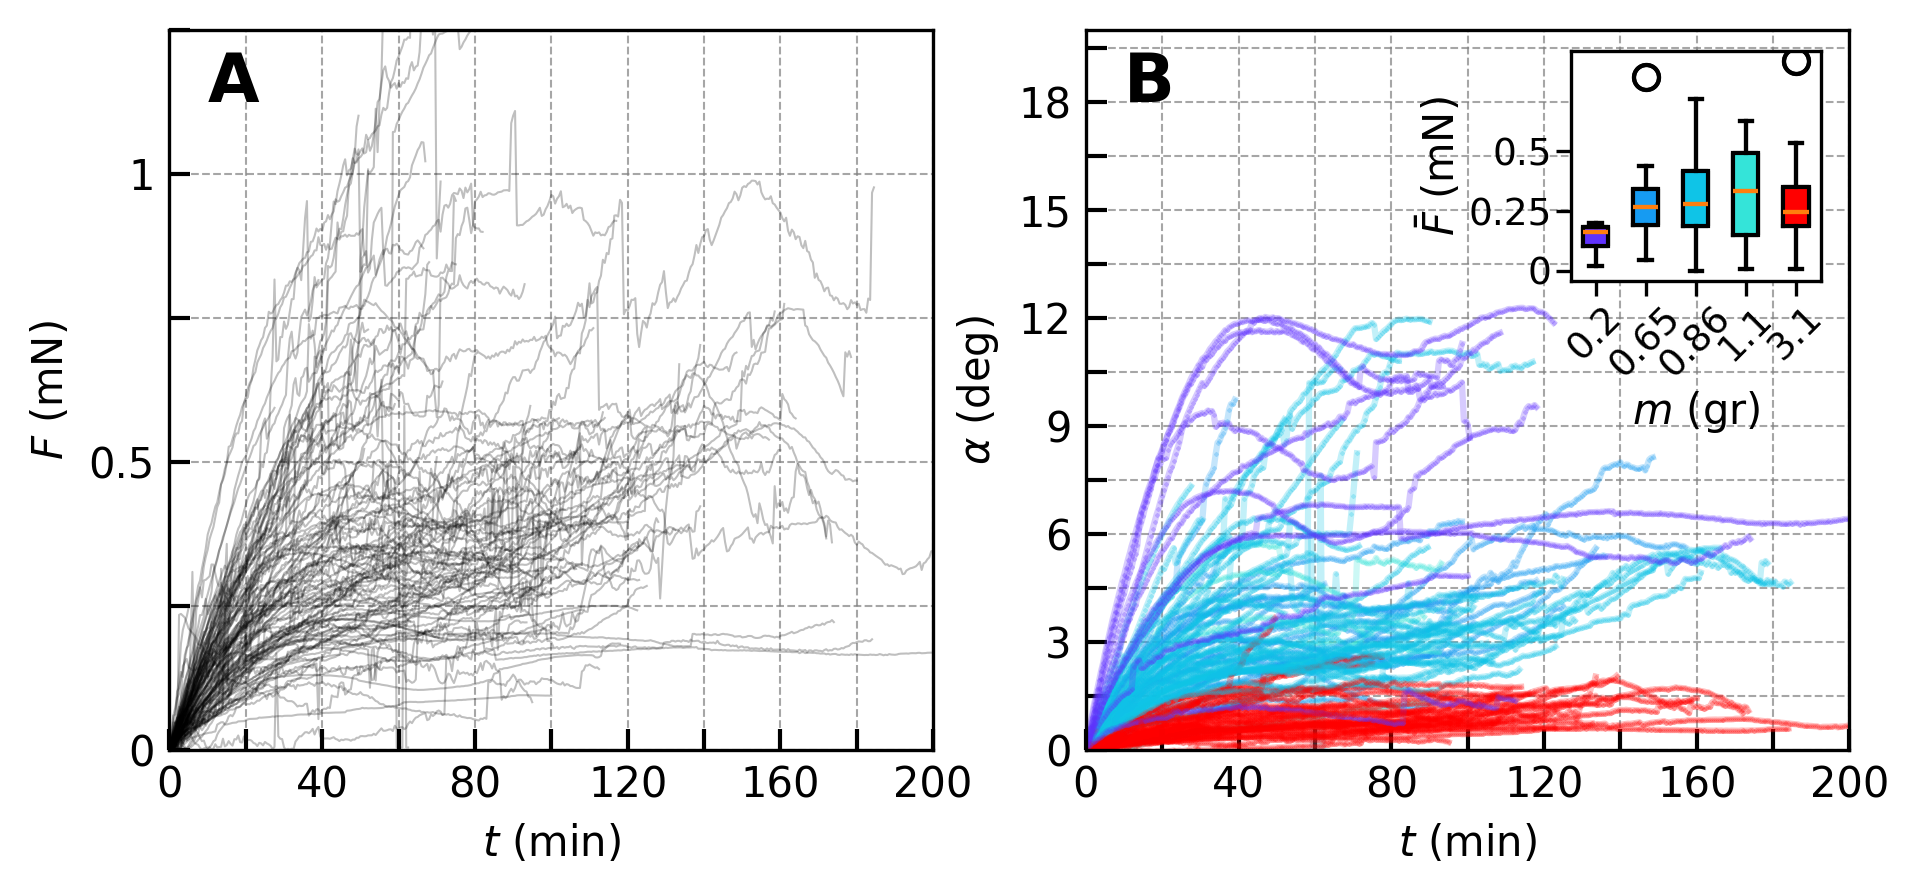

In [20]:
# Plot Force trajectories (A) and angles (B)
# Rod displacement and mean force and per rod mass
from matplotlib.lines import Line2D

# Create the figure

fig, ax = plt.subplots(1, 2, figsize=(7, 3), dpi=300)
ax[0].text(0.05, 0.9, 'A', fontsize=fs, fontweight='bold', transform=ax[0].transAxes)
ax[1].text(0.05, 0.9, 'B', fontsize=fs, fontweight='bold', transform=ax[1].transAxes)

fs = 16
fig.align_labels()  # Align labels for all subplots

# events trajectories
for i in range(len(events)):
    ax[0].plot(events[i].timer/60, events[i].F_bean,
             color='black', alpha=0.25, linewidth = 0.5) #cmap(0.2)

# set grid and labels of main plot
set_grid(ax[0],200,2.5)
ax[0].set_ylim([0,1.25])
ax[0].set_xlim([0,200])
ax[0].set_xlabel(r'$t$ (min)')
ax[0].set_ylabel(r'$F$ (mN)') #,fontsize=fs)


# Angles and mean force and per rod mass

cmap = plt.get_cmap('rainbow')
# mass = [0.2,0.65,0.86,3.1]
mass = [0.2,0.65,0.86,1.1, 3.1]

# all events displacements
for i in range(len(events)):
    # if events[i].event_label != 'Close2axis': continue # remove events close to axis
    if events[i].p.m_sup in mass:
        index = mass.index(events[i].p.m_sup)
        ax[1].plot(events[i].timer/60, np.rad2deg(events[i].alpha) ,marker=
                    'x',markersize=0.5,color=cmap(mass[index]/max(mass)),alpha=0.25)

# set grid and labels of main plot
set_grid(ax[1],200,15)
ax[1].set_ylim([0,20])
ax[1].set_xlim([0,200])
ax[1].set_xlabel(r'$t$ (min)')
ax[1].set_ylabel(r'$\alpha$ (deg)') #,fontsize=fs)

# Ensure the x and y axes are plotted on the same scale
# ax[1].set_aspect('equal', adjustable='box')

# mean force boxplot for all events (upto the first 2 hours)
f_mean = [[] for i in range(len(mass))]
f_max = [[] for i in range(len(mass))]
for i in range(len(events)):
    
    if events[i].p.m_sup in mass:
        index = mass.index(events[i].p.m_sup)
        # check if the event is not too short
        # if events[i].frm_dec_top - events[i].frm0_top > 30:
        f_mean[index].append(np.mean(events[i].F_bean))
            # f_max[1index].append(np.max(events[i].F_bean))
# Create inset axes
ax_inset = inset_axes(ax[1], width="40%", height="40%",# loc='upper right',
                      bbox_to_anchor=(0.17, 0.2,0.82,0.8), bbox_transform=ax[1].transAxes)
# Remove missing values in f_mean
f_mean = [list(filter(lambda x: not np.isnan(x), sublist)) for sublist in f_mean]
# f_max = [list(filter(lambda x: not np.isnan(x), sublist)) for sublist in f_max]

# Add boxplots
ax_inset.boxplot(f_mean, positions=range(len(mass))) # to space the ticks by mass
# ax_inset.boxplot(f_max, positions=range(len(mass))) # to space the ticks by mass

# set box colors
box_colors = [cmap(mass[i] / max(mass)) for i in range(len(mass))]
box = ax_inset.boxplot(f_mean, patch_artist=True, positions=range(len(mass)))
# box = ax_inset.boxplot(f_max, patch_artist=True, positions=range(len(mass)))
for patch, color in zip(box['boxes'], box_colors):
    patch.set_facecolor(color)


# Create inset of the distribution plot
ax_inset.set_xticks(range(len(mass)))
ax_inset.set_xticklabels([f'{m}' for m in mass], rotation=45)#, ha='right')
ax_inset.set_ylabel(r'$\bar{F}$ (mN)',fontsize=10,labelpad=1)
ax_inset.set_xlabel(r'$m$ (gr)',fontsize=10,labelpad=1)

# Control x-tick and y-tick positions
# ax_inset.set_xticks(mass)  # Set specific tick positions
ax_inset.set_xticklabels(mass, fontsize=9)  # Set specific tick labels with fontsize
ax_inset.set_yticks([0, 0.25, 0.5])  # Set specific y-tick positions
ax_inset.set_yticklabels([0, 0.25, 0.5], fontsize=9)  # Set specific y-tick labels with fontsize
# Adjust tick labels' padding
ax_inset.tick_params(axis='x', pad=1)  # Move x-axis labels closer to the ticks
ax_inset.tick_params(axis='y', pad=1)  # Move y-axis labels closer to the ticks

# Adjust the legend properties
# fig.legend(
#     handles=legend_elements,
#     loc='upper left',          # Place in the upper-right corner
#     frameon=False,              # Remove the frame
#     handlelength=0.8,             # Shorter line elements
#     handletextpad=0.2,          # Reduce space between handle and text
#     borderaxespad=0.1,          # Reduce space between legend and inset plot edge
#     fontsize=8                  # Smaller font size for better fit
# )

# adjust layout and show
# fig.subplots_adjust(wspace=0.4)  # Adjust the width space between subplotsplt.tight_layout()
# fig.subplots_adjust(top=0.8, bottom=0.1, left=0.1, right=0.9)  # Adjust as necessary

fig.subplots_adjust(top=0.95, bottom=0.15, left=0.15, right=0.95)  # Adjust as necessary
plt.show()
fig.savefig(save_folder+r'\F_alpha_msup.pdf',dpi=300)
